In [1]:
import numpy as np

class PDE:
    def __init__(self, grid, basis, quadrature, dirichletLocations = (lambda x,y: True), dirichletValues = (lambda x,y: 0.0)):
        self.grid = grid
        self.basis = basis
        self.quadrature = quadrature

        # Initialize 
        self.Stiff = np.zeros((np.shape(self.grid.points)[0],np.shape(self.grid.points)[0]))
        self.Load = np.zeros(np.shape(self.grid.points)[0])
        self.solution = None

        # Boundary Conditions
        self.assembleBoundaryConditions(dirichletLocations, dirichletValues)

        # Gather
        self.__gatherData()


    def __gatherData(self):
        " Precompute data that is needed all the time."
        # x_k and w_k
        self.xkHat,self.wkHat = self.quadrature.getPointsAndWeights()
        # F_T(x_k)
        self.xkTrafo = self.grid.evalReferenceMap(self.xkHat)
        # DF_T -> det and inverse
        self.dets = np.abs(self.grid.getDeterminants())
        self.invJac = self.grid.getInverseJacobians()
        # phi(x_k) and grad_phi(x_k)  
        self.phi = self.basis.evalPhi(self.xkHat)
        self.gradPhi = self.basis.evalGradPhi(self.xkHat)
        
    def reset(self):
        self.Stiff = np.zeros((np.shape(self.grid.points)[0],np.shape(self.grid.points)[0]))
        self.Load = np.zeros(np.shape(self.grid.points)[0])
        self.solution = None

    def setGrid(self, grid):
        self.grid = grid
        self.__gatherData()

    def setBasis(self, basis):
        self.basis = basis
        self.__gatherData()

    def setQuadrature(self, quadrature):
        self.quadrature = quadrature
        self.__gatherData()        

    def assembleBoundaryConditions(self, dirichletLocations, dirichletValues):
        self.dirichletDOFs = self.grid.getBoundaryIndices(dirichletLocations)
        self.allDOFs = np.arange(np.shape(self.grid.points)[0])
        self.freeDOFs = np.setdiff1d(np.arange(np.shape(self.grid.points)[0]),self.dirichletDOFs)

        self.reset()
        
        self.Stiff[self.dirichletDOFs,self.dirichletDOFs] = 1.0
        self.Load[self.dirichletDOFs] = dirichletValues(self.grid.points[self.dirichletDOFs,0],self.grid.points[self.dirichletDOFs,1])
        
        
    def addLoad(self, f):
        self.solution = None 
        
        for i in self.freeDOFs: 
            ### BEGIN SOLUTION
            supp,localInd = self.grid.evalDOFMap(i)
            for T,loc_i in zip(supp,localInd):
                self.Load[i] += self.dets[T] * np.sum(self.phi[:,loc_i] * self.wkHat * f(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]))

            ### END SOLUTION
            
    def addDiffusion(self, a):
        self.solution = None
        
        for i in self.freeDOFs:
            for j in self.allDOFs:
                ### BEGIN SOLUTION
                supp_I,localIndices_I = self.grid.evalDOFMap(i)
                supp_J,localIndices_J = self.grid.evalDOFMap(j)
                    
                supp_IJ,tmpLocalIndices_I,tmpLocalIndices_J = np.intersect1d(supp_I,supp_J,assume_unique=False,return_indices=True)
                localIndices_I = localIndices_I[tmpLocalIndices_I]
                localIndices_J = localIndices_J[tmpLocalIndices_J]
                
                for T,loc_i,loc_j in zip(supp_IJ,localIndices_I,localIndices_J):
                    for k in range(self.xkHat.shape[0]):
                        self.Stiff[i,j] += a(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]) * self.dets[T] * self.wkHat[k] * np.dot(np.dot(self.invJac[T,:,:],self.gradPhi[k,loc_j,:]),np.dot(self.invJac[T,:,:],self.gradPhi[k,loc_i,:]))
                ### END SOLUTION        
                        
    def addConvection(self, b):
        self.solution = None
        
        for i in self.freeDOFs:
            for j in self.allDOFs:       
                ### BEGIN SOLUTION
                supp_I,localIndices_I = self.grid.evalDOFMap(i)
                supp_J,localIndices_J = self.grid.evalDOFMap(j)
                    
                supp_IJ,tmpLocalIndices_I,tmpLocalIndices_J = np.intersect1d(supp_I,supp_J,assume_unique=False,return_indices=True)
                localIndices_I = localIndices_I[tmpLocalIndices_I]
                localIndices_J = localIndices_J[tmpLocalIndices_J]
                
                for T,loc_i,loc_j in zip(supp_IJ,localIndices_I,localIndices_J):
                    for k in range(self.xkHat.shape[0]):
                        print(b(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]))
                        print(np.dot(self.invJac[T,:,:],self.gradPhi[k,loc_j,:]))
                        print(np.dot(b(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]),np.dot(self.invJac[T,:,:],self.gradPhi[k,loc_j,:])))
                        self.Stiff[i,j] +=  self.dets[T] * self.wkHat[k] * np.dot(b(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]),np.dot(self.invJac[T,:,:],self.gradPhi[k,loc_j,:])) * self.phi[k,loc_i]
                ### END SOLUTION
                        
    def addReaction(self, c):
        self.solution = None
        
        for i in self.freeDOFs:
            for j in self.allDOFs:      
                ### BEGIN SOLUTION
                supp_I,localIndices_I = self.grid.evalDOFMap(i)
                supp_J,localIndices_J = self.grid.evalDOFMap(j)
                        
                supp_IJ,tmpLocalIndices_I,tmpLocalIndices_J = np.intersect1d(supp_I,supp_J,assume_unique=False,return_indices=True)
                localIndices_I = localIndices_I[tmpLocalIndices_I]
                localIndices_J = localIndices_J[tmpLocalIndices_J]
                    
                for T,loc_i,loc_j in zip(supp_IJ,localIndices_I,localIndices_J):
                    for k in range(self.xkHat.shape[0]):
                        self.Stiff[i,j] +=  self.dets[T] * self.wkHat[k] * c(self.xkTrafo[T,0,:],self.xkTrafo[T,1,:]) * self.phi[k,loc_j] * self.phi[k,loc_i]
                ### END SOLUTION
                        
    def solve(self):
        self.solution = np.linalg.solve(self.Stiff,self.Load)

    def getSolution(self):
        if self.solution is None:
            self.solve()

        return self.solution    

    def plotSolution(self):
        if self.solution is None:
            self.solve()

        self.grid.plotDOFVector(self.solution)

In [2]:
from grid import Grid
from basis import Basis
from quadrature import Quadrature

grid = Grid(-2,2,-2,2,40,40,True)
basis = Basis(1)
quadrature = Quadrature(1,1)

p = PDE(grid,basis,quadrature)

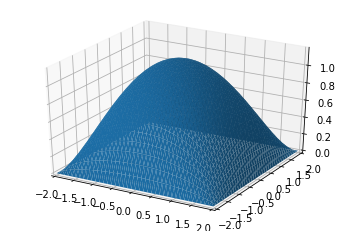

In [3]:
# Diffusion
a = lambda x,y: 1.0
p.addDiffusion(a)
# Load
f = lambda x,y: 1.0
p.addLoad(f)

p.plotSolution()

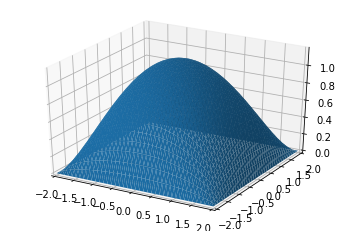

In [4]:
# Setting BC resets the whole system
dirichletLocation = lambda x,y: (x**2 + y**2) > 1
dirichletValues = lambda x,y: 0
p.assembleBoundaryConditions(dirichletLocation, dirichletValues)

# Reset to Poissons Equation
p.addDiffusion(a)
p.addLoad(f)

p.plotSolution()